# Tutorial

Example of how to use code written as of May 2021 for mPFC analyses on a single day



Session: `data_sdc_20190902_145404_fromSD`

Current data storage:
* raw .dat, .rec, .mda, .bin and preprocessed .bin files are located on scratch under ``

* sorted data is located on bucket `Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata`

* in a sorted folder: 
    * folder for each .bin bundle & cluster notes, matlab struct w/ spike info from scraped phy, matlab struct w/ behavior info scraped from bdata
    * sessions aligned .pkl files 
    * in .bin bundle folder you will find curated kilosort output, mask info as npy and preprocessed .bin that was run

see [jbreda_PWM_ephys_analysis](https://github.com/Brody-Lab/jbreda_PWM_ephys_analysis) for more info on how this info was obtained


## Libraries and paths

In [1]:
# libraries

import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
import warnings
import pydove as dv
from IPython.display import Image

from cycler import cycler
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from io_utils import *
from plotting_utils import * 

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

In [2]:
# session name
sess_name = 'data_sdc_20190902_145404_fromSD'

# path information
base_path  = 'X:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'

# make paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)

## Load In

#### A set of functions written to take matlab structs and kilosort output and import into python. 

They add additional information to behavior info (e.g. what was the first sound in dB for each trial). You can speed up run time by loading these files in if they are already saved in the session's folder. If path doesn't exist, make sure you're connected to bucket.

In [3]:
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)

#### What the behavior information looks like:

In [4]:
beh_df.head()

,trial_num,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off,louder,first_sound
0,19,hit,4,5,LEFT,LEFT,0.001000,0.002700,638.592225,645.952226,644.708217,638.643221,639.043233,643.043224,643.442229,aud_2,60*
1,20,hit,6,5,LEFT,LEFT,0.001000,0.002700,652.103221,661.256217,659.849224,652.154222,652.553231,658.553227,658.953227,aud_2,60*
2,22,hit,2,1,RIGHT,RIGHT,0.002700,0.001000,672.617221,677.762223,676.540220,672.667224,673.067227,675.067231,675.467238,aud_1,68
3,23,hit,2,1,RIGHT,RIGHT,0.002700,0.001000,684.046215,689.180224,687.884237,684.096224,684.496236,686.496224,686.896231,aud_1,68
4,24,hit,4,8,LEFT,RIGHT,0.019683,0.053144,694.376218,701.768215,700.364220,694.426220,694.826222,698.826221,699.226219,aud_2,84


#### Information stored in spks_dict:

In [5]:
spks_dict.keys()

dict_keys(['date', 'spk2fsm', 'fs', 'trode_nums', 'spk_qual', 'spk_times', 'mean_wav', 'std_wav'])

#### Checking if the 2nd cell in the session is a single or multi unit:

In [6]:
spks_dict['spk_qual'][1]

'multi'

## Aligning spike times to trial events

#### This allows you to go from a very long 1d vector with spike times for a cell for the whole session to a list of lists with dimensions n trial by n spikes per trial. Then, it centers the trial spikes based on an stimuli events (e.g. aud 1 on). 

Again, you can overwrite or load in if the file_name is present. Additionally, if you want to have information for separate delay times (e.g. 2 and 4 second trials) you can turn delay_mode on. (Note, I don't really use delay mode right now and analyze the first 2s of all trial types).

In [7]:
session_aligned, session_windows = event_align_session(spks_dict, beh_df, sess_path, overwrite=True,
                                                      delay_mode=False, file_name='tutorial_all_trials.pkl')

no file found, running alignment for session


In [8]:
print(f"There are {len(session_aligned)} neurons in this session.")

There are 4 neurons in this session.


#### Example of events aligned to. Note, these keys are the same for all neurons

In [9]:
neuron = 0

session_aligned[neuron].keys()

dict_keys(['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all', 'delay_overlap'])

#### If you want to know the time windows used around the alignment period you can see them in the `session_windows`. 
Note, these are hard coded into `stimuli_align()` and `delay_align()` for now, and are in miliseconds. These functions also have information on which event was algined to. For example, `delay_overlap` is for analyzing the first 2 seconds of the delay period. It is aligned to `aud 1 off` and has large tails (`+/- 600 ms`) to reduce edge effects when smoothing with a large guassian filter over the delay period.

In [10]:
session_windows[neuron]

{'aud1on': [-400, 600],
 'aud1off': [-500, 500],
 'aud2on': [-400, 600],
 'aud2off': [-500, 500],
 'trial_all': [-100, 5000],
 'delay_overlap': [-600, 2600]}

#### Example of what a single aligned trial looks like for an event. These times are in seconds relative to the event.

In [11]:
event = 'aud1on'
trial = 32

session_aligned[neuron][event][trial]

array([-0.39722631, -0.37669406, -0.34916219, -0.31359742, -0.21560263,
       -0.15223933,  0.34773408,  0.38099898,  0.39576486,  0.50119259,
        0.53855727])

### What if I only want to plot hit trials?

#### Right now, the easiest way to do that is filter the dataframe you pass into `event_align_session()`. 

Alternatively, you could filter which trials you use from `session_aligned`. Eventually, it would be nice to have `event_align_session` be an object with filtering abilities. 

In [12]:
# hits only
hit_df = beh_df[beh_df['hit_hist'] == 'hits']

# softest and louded first sounds and hits
sound_list = ['60*', '92*']
filtered_df = beh_df[(beh_df['first_sound'].isin(sound_list)) & (beh_df['hit_hist'] == 'hit')]

_,_ = event_align_session(spks_dict, hit_df, sess_path, overwrite=False,
                          delay_mode=False, file_name='tutorial_hit_trials.pkl')

loading from file...


## Plotting: Rasters

#### This takes advantage of the eventplot code. Eventually, a flexible function would be good here, but this works for now.

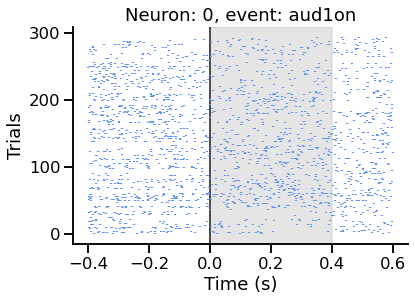

In [13]:
fig, ax = plt.subplots()

_ = ax.eventplot(session_aligned[neuron][event], color = 'cornflowerblue')

# aesthetics
ax.axvspan(0,0.000001, color = 'black')
ax.set_title(f"Neuron: {neuron}, event: {event}")
ax.axvspan(0,.4, alpha = 0.2, color = 'gray')
ax.set(xlabel="Time (s)", ylabel='Trials')
sns.despine()



#### Plotting multiple rasters given a condition for a single neuron.

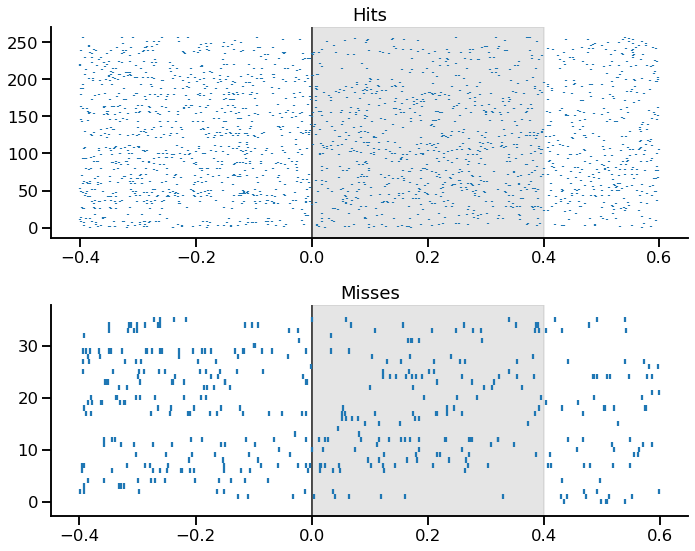

In [14]:
conditions = 'hit_hist'

# this dictionary will have the indices for each condition
trials = dict()
for cond_id in np.sort(beh_df[conditions].unique()):
    trials[cond_id] = np.where((beh_df[conditions] == cond_id).values)[0]


# intialize figure
fig, ax = plt.subplots(len(trials), figsize= (10, 8)) 

counter = 0
for cond_id, idxs in trials.items():

    # grab the trials for each condition
    selected_trials = np.array(session_aligned[neuron][event], dtype=object)[idxs]
    
    # make the plot
    _ = ax[counter].eventplot(selected_trials)
    ax[counter].axvspan(0,0.000001, color = 'black')
    ax[counter].axvspan(0,0.4, alpha = 0.2, color = 'grey')
    
    # adding titles here
    ax[0].set_title('Hits')
    ax[1].set_title('Misses')
    
    # manual counter (fix this eventually)
    counter+=1
    
plt.tight_layout()
sns.despine()

## Plotting: PSTH (boxcar)

#### You can make a simple boxcar PSTH from the `session_aligned` spike data. 

In [15]:
boxcar_psth = PSTH_boxcar(session_aligned[neuron], session_windows[neuron], 
                          event=event, df=beh_df, conditions='hit_hist', 
                         bin_size=0.100, masking=False)

for hit there are 258 trials for this session
for miss there are 36 trials for this session


#### This returns a dictionary with information on what was used to make the psth, and data for plotting.

In [16]:
boxcar_psth.keys()

dict_keys(['event', 'conditions', 'n', 'time', 'data', 'mean', 'sem'])

In [17]:
boxcar_psth['n'], boxcar_psth['mean'],

([258, 36],
 {'hit': array([15.62015504, 12.59689922, 13.52713178, 10.23255814,  9.68992248,
          9.30232558, 10.34883721, 10.46511628,  9.10852713, 11.74418605]),
  'miss': array([17.5       , 16.11111111, 13.33333333, 10.        ,  9.72222222,
         13.05555556, 10.55555556,  7.22222222,  8.61111111, 10.        ])})

#### To plot, you can use the `plot_psth` function which has multiple kwargs for aesthetics. If you want to change plot colors, use the maplotlib plot cycler

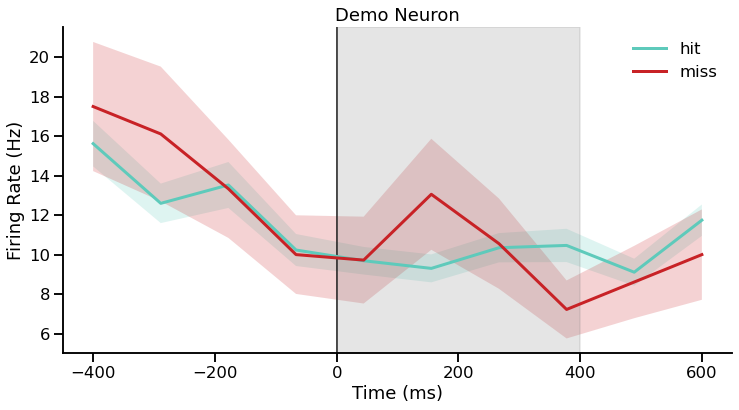

In [18]:
fig,ax = plt.subplots(figsize=(12,6))

hit_miss_cycler = cycler(color=['#5ECABB','#C82226'])
ax.set_prop_cycle(hit_miss_cycler)

plot_psth(boxcar_psth, ax=ax, title='Demo Neuron', legend=True, stimulus_bar='sound on')

#### To have a smoother psth, you can use the `PSTH_guassian` function with the same plotting. This uses scipy.ndimage to convolve a binarized spike train (created with specified `bin_size` that defualts to 1 ms) via a guassian kernal with a specified `sigma`. 

In [19]:
gaussian_psth = PSTH_gaussain(session_aligned[neuron], session_windows[neuron],
                             event=event, df=beh_df, conditions='hit_hist', 
                             sigma=50)

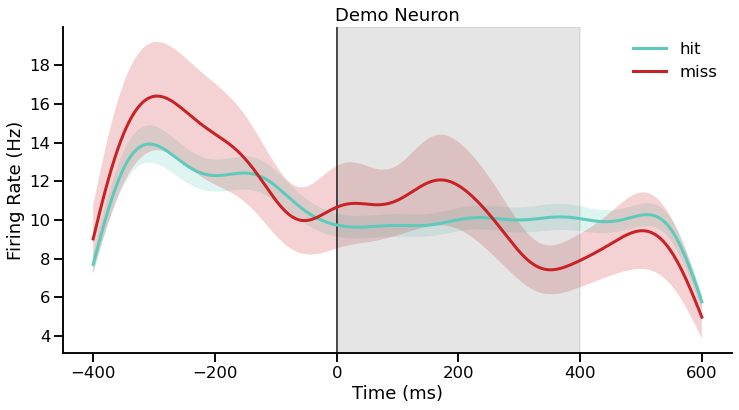

In [20]:
fig,ax = plt.subplots(figsize=(12,6))

hit_miss_cycler = cycler(color=['#5ECABB','#C82226'])
ax.set_prop_cycle(hit_miss_cycler)

plot_psth(gaussian_psth, ax=ax, title='Demo Neuron', legend=True, stimulus_bar='sound on')

#### Crop edge effects in the plot

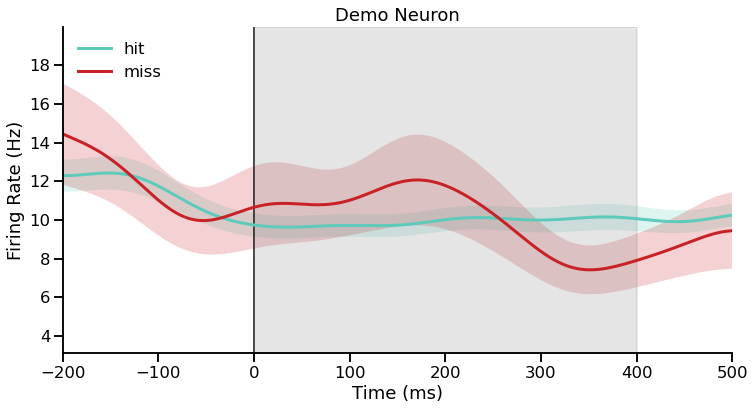

In [21]:
fig,ax = plt.subplots(figsize=(12,6))

hit_miss_cycler = cycler(color=['#5ECABB','#C82226'])
ax.set_prop_cycle(hit_miss_cycler)

plot_psth(gaussian_psth, ax=ax, title='Demo Neuron', legend=True, stimulus_bar='sound on',xlim=(-200,500))

# Analysis: firing rate ~ condition

#### Say you want to look at the average firing rate during the first sound period for hit and miss trials.

To do this, you can use the `fr_by_condition_df()` function. This will make a data frame that is n trials long with the average firing rate over a specificed window and for the condition.

The window is a little fineky and should be updated eventually. Here, I only want to look at the time during the 400 ms sound presendation. When aligned to aud 1 on, this occurs from 0 to 400 ms, but to grab that specific window of time, I need to find the correct indices.

This is easy for a guassian smoothed psth be there are 1 ms bins, and I know the trial goes from -400 to +600 ms (see `session_windows` below). So, to get 0,400 ms I need to grab indices `[400:-200]`

In [22]:
print(f"The time window included around the first sound is {session_windows[neuron]['aud1on']} miliseconds")

The time window included around the first sound is [-400, 600] miliseconds


In [23]:
aud1_by_hits = fr_by_condition_df(gaussian_psth, neuron_id='Example neuron',
                                  window=(400,-200), loudness=False)

In [24]:
aud1_by_hits.head()

,firing_rate,condition,neuron_id
0,6.641460,hit,Example neuron
1,6.254506,hit,Example neuron
2,18.790350,hit,Example neuron
3,9.742864,hit,Example neuron
4,20.559619,hit,Example neuron


#### Plot the firing rate by condition

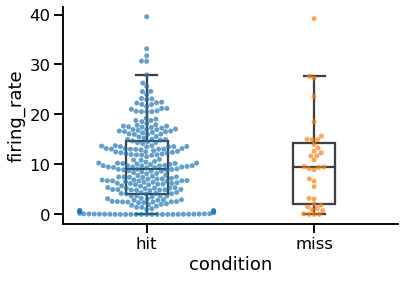

In [25]:
fig, ax = plt.subplots()

ax = sns.boxplot(x='condition', y='firing_rate', data=aud1_by_hits, width=0.25, showfliers=False,
                 boxprops={'facecolor':'none'}, zorder=1)

ax = sns.swarmplot(x='condition', y='firing_rate', data=aud1_by_hits, alpha = .7)

sns.despine()

#### T-test the firing rate by condition

In [26]:
# seperate out the firing rates for the two conditions
hit = aud1_by_hits.query('condition == "hit"')['firing_rate']
miss = aud1_by_hits.query('condition == "miss"')['firing_rate']

# run two sided t,testt
tstat, pval, degfree = ttest_ind(hit.dropna(),miss.dropna())

print(f"The p-value for this neuron comparing the firing rate during the first sound on for hit and miss trials is {pval:0.2f}")

The p-value for this neuron comparing the firing rate during the first sound on for hit and miss trials is 0.88


# Analysis: delay firing rate ~ first sound

#### This replicates the analysis from [Romo et al. 1999](https://pubmed.ncbi.nlm.nih.gov/10365959/).

But rather than looking at each slice of time, it looks at the whole 2s delay period for all trials.

In [27]:
fig_save_path = os.path.join(os.getcwd(), 'figures', 'tutorial', 'delay')
if os.path.exists(fig_save_path):
    print('fig save path exists')
else:
    os.makedirs(fig_save_path)

# assign event
event = 'delay_overlap'

# remove pyschometric sounds and only look at hits
filtered_df = beh_df[(beh_df['first_sound'] != 'psycho') & (beh_df['hit_hist'] == 'hit')]

# align data to filtered df
sess_aligned, sess_windows = event_align_session(spks_dict, filtered_df, sess_path, overwrite=False,
                                            delay_mode=True, file_name='tutorial_delay_overlap.pkl')

# run analyze & plot loduness
stats_df, loudness_df = analyze_and_plot_loudness(sess_name, sess_aligned, sess_windows, event, filtered_df, fig_save_path)



fig save path exists
loading from file...
Plotting data_sdc_20190902_145404_fromSD_N0
Plotting data_sdc_20190902_145404_fromSD_N1
Plotting data_sdc_20190902_145404_fromSD_N2
Plotting data_sdc_20190902_145404_fromSD_N3


In [28]:
stats_df

,neuron_id,rsqaured,pvalue
0,data_sdc_20190902_145404_fromSD_N0,0.102296,0.000007
0,data_sdc_20190902_145404_fromSD_N1,0.011600,0.140168
0,data_sdc_20190902_145404_fromSD_N2,0.060225,0.000665
0,data_sdc_20190902_145404_fromSD_N3,0.027912,0.021577


#### From the stats dataframe it looks like 3 neurons in this session have a significant slope when regression firing rate ~ first sound loudness, lets look at one of them.

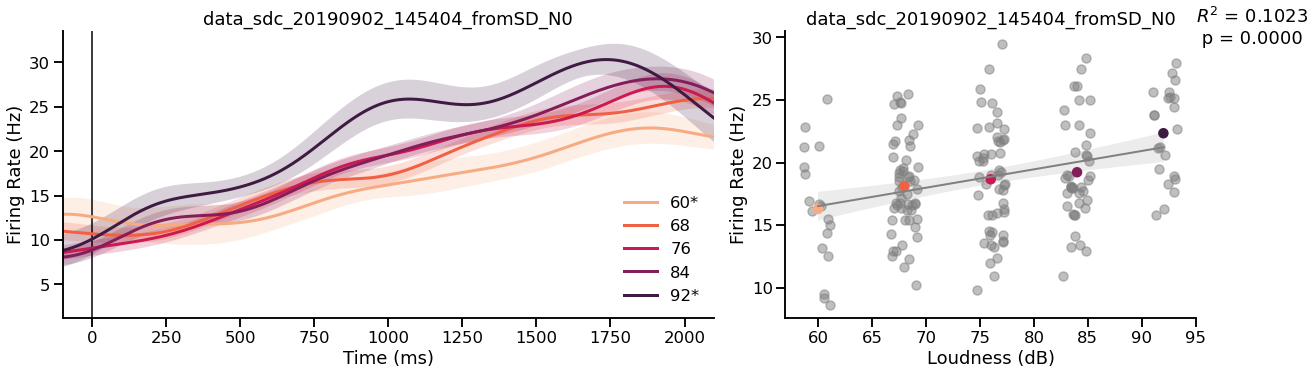

In [29]:
Image(filename=os.path.join(fig_save_path, 'data_sdc_20190902_145404_fromSD_N0_delay_overlap_dual_delay_plot.png' ))

# Analysis: firing rate ~ correct side

#### This is a quick analysis to look at how firing rate may change by correct side during the delay period.

Like the delay analysis code above, it will create all the plots and then run a t-test. Note: moving forward, I won't be using this condition very muhc, but it was a jumping off point to write a code backbone for questions like this. And, it demonstrates that looking into mean loudness of sounds for L/R, or something along those lines, could be beneficial long term.

In [30]:
fig_save_path = os.path.join(os.getcwd(), 'figures', 'tutorial', 'correct_side')
if os.path.exists(fig_save_path):
    print('fig save path exists')
else:
    os.makedirs(fig_save_path)

# assign event
event = 'delay_overlap'

# only want to look at hits or misses
noviol_df = beh_df[beh_df['hit_hist'] != 'viol']

sess_aligned, sess_windows = event_align_session(spks_dict, noviol_df, sess_path, 
                                                 overwrite=True, delay_mode=False, 
                                                 file_name='tutorial_noviol.pkl')

stats_df = analyze_and_plot_correct_side(sess_name, sess_aligned, sess_windows, 
                                        event, noviol_df, fig_save_path)

fig save path exists
no file found, running alignment for session
Plotting data_sdc_20190902_145404_fromSD_N0
Plotting data_sdc_20190902_145404_fromSD_N1
Plotting data_sdc_20190902_145404_fromSD_N2
Plotting data_sdc_20190902_145404_fromSD_N3


In [31]:
stats_df

,neuron_id,pvalue
0,data_sdc_20190902_145404_fromSD_N0,0.029953
0,data_sdc_20190902_145404_fromSD_N1,0.824583
0,data_sdc_20190902_145404_fromSD_N2,0.007133
0,data_sdc_20190902_145404_fromSD_N3,0.979280


#### From the stats dataframe it looks like 2 neurons in this session have a significant slope when regression firing rate ~ correct side, lets look at one of them.

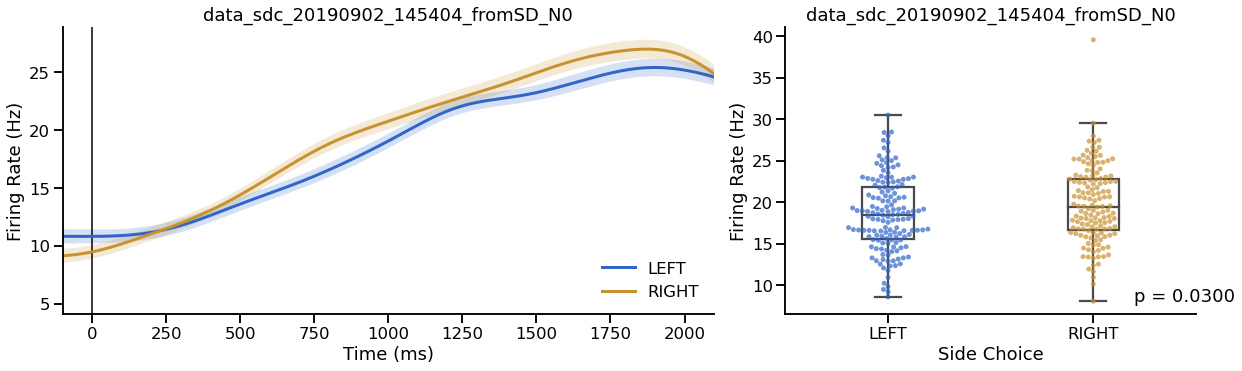

In [32]:
Image(filename=os.path.join(fig_save_path, 'data_sdc_20190902_145404_fromSD_N0_delay_overlap_correct_side.png' ))

# Iterating over all neurons, sessions

To do this, I load all the spike and behavior data into one notebook and loop over it. Look in the `2021_05_18_LabMtg` Notebook to see in more detail. A script that runs for each session would likely be nicer. Additionally I have a `selective_load_and_wrangle()` function. This only loads in information for a subset of cells in a session. So, if you know the cells that have low firing rates, and you don't want to analyze them, you can pass in the cells you want via a list.